In here I have tried to classify the categories of each text in the fetch_20newsgroups dataset belongs to. Different vector representation of the text, ML techniques (supervised and unsupervised) and hyperparameters (using GridSearchCV) were tested. In short, when text is represented by the averaged GloVE vectors of the noun chunks in the text, the resulting vector representation would gives high accuracy performance in all the ML models tested (SVM, K-nearest neighbours and K-means clustering). 

In [39]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

The dataset that is being used is the fetch_20newsgroups that can be imported from the sk-learn library. It contains around 18000 pieces of labelled text which are categorised into 20 classes. The headers, footers and quotes usually gives out a lot of hint regarding the categories the text belongs to and therefore resulting is a really high accuracy rate. It would be more ideal however, if we could develop a model that can accurately predict the classes based just on the text body, and therefore the headers, footers and quotes are removed from each training example.


First, the text is transformed into a Term Frequency–Inverse Document Frequency (tf-idf) vectors and Multinomial Naive Bayes and SVM (SGDClassifier) were tested.

In [140]:
train_set = fetch_20newsgroups(subset = "train", shuffle = True, remove = ("headers", "footers", "quotes"))
test_set = fetch_20newsgroups(subset = "test", shuffle = True, remove = ("headers", "footers", "quotes"))

In [139]:
tfidf  = TfidfVectorizer()
Mn_clf = Pipeline([('tfidf', TfidfVectorizer()),
                      ('clf', MultinomialNB())])
Mn_clf = Mn_clf.fit(train_set.data, train_set.target)
print ("MultinomialNB: " + str(Mn_clf.score(test_set.data, test_set.target)))

#Gaussian commented out because it's too slow (need to transform to dense vector)
# G_clf = Pipeline([('tfidf', TfidfVectorizer()), 
#                   ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse = True)),
#                       ('clf', GaussianNB())])
# G_clf = G_clf.fit(train_set.data, train_set.target)
# print ("GausianNB: " + str(G_clf.score(test_set.data, test_set.target)))

SVM_clf = Pipeline([("tfidf", TfidfVectorizer()),
                    ("SGDClassifier", SGDClassifier())])
SVM_clf.fit(train_set.data, train_set.target)

print ("SVM (SGD): " + str(SVM_clf.score(test_set.data, test_set.target)))

MultinomialNB: 0.6062134891131173


C:\Users\user\Anaconda3\envs\chatbot\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SVM (SGD): 0.6931757833244823


Now it can be seen that SVM perform a lot better than a MultinomialNB does and therefore I decided to do tuning on the hyperparameters with GridSearchCV. But before doing it, notice that by default the train and test set is split in 60:40. This is not really neccessary especially when I am doing 5-fold CV during the grid search anyway. Therefore I splitted the dataset into training and testing set with approximately a 80:20 ratio instead.

In [166]:
print (len(train_set.data)/ (len(train_set.data) + len(test_set.data)))
print ((len(train_set.data) + len(test_set.data)) * 0.8)
whole_set = fetch_20newsgroups(subset = "all", shuffle = True, remove = ("headers", "footers", "quotes"))
X_train, X_test, y_train, y_test = train_test_split(whole_set.data, whole_set.target, test_size = 0.2, random_state = 10)
print (len(X_train), len(X_test))

0.6003395946089356
15076.800000000001
15076 3770


Several parameters were tested as indicated in the parameters dictionary. Also stop words were removed because more often than not they reduces performance of text classification. max_df is the maximum document frequency that the word can have in order to be included in the vocabulary. This eliminates terms that appears too frequent (just like stop-words) and therefore might not bear much use for the classificaiton problem. In contrast, min_df eliminates terms that appears too few times (e.g. misspelled words). 

During Grid Search, 5-fold cross-validation is performed and refit is set to True so that in the end, the best estimator is trained again but this time with the entire training data (no validation set).

In [ ]:
SVM_clf = Pipeline([("tfidf", TfidfVectorizer()),
                    ("SGDClassifier", SGDClassifier())])

parameters = {"tfidf__ngram_range": [(1,1), (1,2), (1,3)],
              "tfidf__max_df": [0.3,0.5,1.0],
              "tfidf__max_features": [None, 25000],
              "tfidf__min_df": [5,10],
             "tfidf__stop_words": ["english",],
              "SGDClassifier__alpha": [0.0001, 0.0002]}


SVM_clf_gs = GridSearchCV(SVM_clf, parameters, n_jobs = -1, refit = True, cv = 5)
SVM_clf_gs = SVM_clf_gs.fit(X_train, y_train)



In [148]:
print ("best CV score: " + str(SVM_clf_gs.best_score_))
print ("best parameters: " + str(SVM_clf_gs.best_params_))
print("test score: " + str(SVM_clf_gs.score(X_test, y_test)))

best CV score: 0.7468
best parameters: {'SGDClassifier__alpha': 0.0001, 'tfidf__max_df': 0.5, 'tfidf__max_features': None, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english'}
test score: 0.7524700988039521


Notice how the test score is slightly that the CV score, this could be a result of the fact that the CV score is an averaged out score, where there could be a high variance in each of the individual CV score. Also, the model is refitted to the entire dataset, which can result in a better performance.

Next I decided to tried Unsupervised learning (K-mean clustering) to solve the classification problem. For simiplicity sake, I have started this task with only 2 catagories of data so it is easier to measure the accuracy of the K-mean clustering model. I have also tested the performance of SVM as well as K-nearest neighbors because I wanted to see how much changing the features can affect the performances.

I have also noticed that there are training example in the dataset that are just empty string, so because of that, I have filtered out all the data that is an empty string.

In [174]:
from sklearn.metrics import homogeneity_completeness_v_measure

def scoring(clf, train_x, test_x, train_y, test_y):
    name = clf[0]
    clf = clf[1]
    if name != "KMEANS":
        clf.fit(train_x, train_y)
        return (name + " accuracy: " + str(clf.score(test_x, test_y)) )
    else:
        clf = clf.fit(train_x)
#        print (max(np.mean(KM_clf.predict(train_x) == train_y), 1-np.mean(KM_clf.predict(train_x) == train_y)))
        acc = str(max(np.mean(clf.predict(test_x) == test_y), 1- np.mean(clf.predict(test_x) == test_y)))
        hcv = homogeneity_completeness_v_measure(test_y, clf.predict(test_x))
        return ("{0} accuracy: {1}, homo: {2}, comp: {3}, vm: {4}".format(name, acc, *hcv))

In [188]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
cats = ["rec.autos", 'talk.religion.misc']
data_set = fetch_20newsgroups(subset = "all", shuffle = True, remove = ("headers", "footers", "quotes"), categories = cats)

text, target = data_set.data, data_set.target
print (len(text))
text = []
target = []
for i in range(len(data_set.data)):
    if len(data_set.data[i]) > 10:
        text.append(data_set.data[i])
        target.append(data_set.target[i])
print (len(text)) 

vectors = TfidfVectorizer(ngram_range = (1,2), max_df = 0.5, min_df = 5, stop_words = "english")
features = vectors.fit_transform(text)

clfs = {"SVM": SGDClassifier(random_state  = 10, alpha = 0.0001), 
        "KMEANS": KMeans(n_clusters = 2, n_jobs = -1, random_state = 10),
        "K-nearest": KNeighborsClassifier()}

for clf in clfs.items():
    print (scoring(clf, *train_test_split(features, target, test_size = 0.2, random_state = 10)))

1618
1538


C:\Users\user\Anaconda3\envs\chatbot\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SVM accuracy: 0.9253246753246753
KMEANS accuracy: 0.762987012987013, homo: 0.23602164328037573, comp: 0.35654418939491794, vm: 0.28402631688408747
K-nearest accuracy: 0.6428571428571429


It can be seen that SVM is really accurate in solving this particular binary classification problem when comparing to K-nearest neighbour and K-mean clustering. 

Next I am going to attempt to change the vector representation of each text from being a bag of Tf-idf values to a vector derived by averaging the GloVE vectors of its corresponding words. Hopefully, the semantic relationship that GloVE vectors are able to represent will help the data of each label to cluster better in the feature space.



In [177]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [185]:
vectors = [nlp(t).vector for t in text]
clfs = {"SVM": SGDClassifier(random_state  = 10, alpha = 0.0001), 
        "KMEANS": KMeans(n_clusters = 2, n_jobs = -1, random_state = 10),
        "K-nearest": KNeighborsClassifier()}

for clf in clfs.items():
    print (scoring(clf, *train_test_split(vectors, target, test_size = 0.2, random_state = 10)))

C:\Users\user\Anaconda3\envs\chatbot\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SVM accuracy: 0.9545454545454546
KMEANS accuracy: 0.5714285714285714, homo: 0.005843777657012184, comp: 0.01573009968288095, vm: 0.008521713887694652
K-nearest accuracy: 0.922077922077922


Turns out that while K-nearest neighbour were able to perform much better, the unsupervised K-mean clustering method is still had quite a large decrease in performance. I suspected that this could be due to the stop word not being removed so the next thing to do is to remove the stop word from being used for the vector computation.

In [186]:
from nltk.corpus import stopwords

sws = set(stopwords.words("english"))

text = [" ".join([word.text for word in nlp(t) if word.text not in sws]) for t in text]
vectors = [nlp(t).vector for t in text]

clfs = {"SVM": SGDClassifier(random_state  = 10, alpha = 0.0001), 
        "KMEANS": KMeans(n_clusters = 2, n_jobs = -1, random_state = 10),
        "K-nearest": KNeighborsClassifier()}

for clf in clfs.items():
    print (scoring(clf, *train_test_split(vectors, target, test_size = 0.2, random_state = 10)))

C:\Users\user\Anaconda3\envs\chatbot\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SVM accuracy: 0.9512987012987013
KMEANS accuracy: 0.8701298701298701, homo: 0.44902065783126033, comp: 0.438862836746917, vm: 0.44388364207043585
K-nearest accuracy: 0.9383116883116883


And as it turns out, it significantly improved the performances in the unsupervised learning model. 
Finally, I would to be more specific in what is used to computed the vectors for each body of text. For example, if a human were given a task to classify the text's category, it might be intuitive for a human to pay more attention to the noun in the text, as they are most indicative of what the category is. Similarly, if we were doing sentiment analysis, it might be 
intuitive to look at the adjective words to decide the sentiment of the text.

Therefore, only the GloVE vector of the noun chunks were used to compute the vector representation of the text:

In [187]:
text = [" ".join([chunk.text for chunk in nlp(t).noun_chunks if chunk.text not in sws]) for t in text]
vectors = [nlp(t).vector for t in text]

clfs = {"SVM": SGDClassifier(random_state  = 10, alpha = 0.0001), 
        "KMEANS": KMeans(n_clusters = 2, n_jobs = -1, random_state = 10),
        "K-nearest": KNeighborsClassifier()}

for clf in clfs.items():
    print (scoring(clf, *train_test_split(vectors, target, test_size = 0.2, random_state = 10)))

C:\Users\user\Anaconda3\envs\chatbot\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SVM accuracy: 0.9285714285714286
KMEANS accuracy: 0.9058441558441559, homo: 0.5412801758111346, comp: 0.5380345075451398, vm: 0.5396524615617748
K-nearest accuracy: 0.9415584415584416


All three models now reaches an above 90% accuracy. Interestingly, both K-nearest neighbour and K-mean clustering had improved significantly from an accuracy of around 65-75% when using a tf-idf vector representation to 90% range.

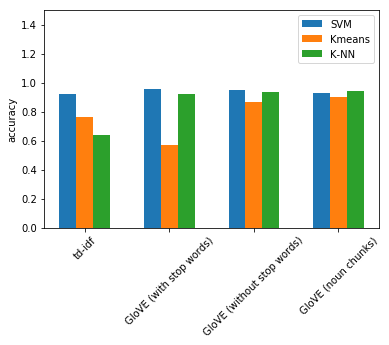

In [205]:
import matplotlib.pyplot as plt
plt.figure()

SVM= [ 0.9253246753246753, 0.9545454545454546, 0.9512987012987013, 0.9285714285714286]
KMEANS = [0.762987012987013, 0.5714285714285714, 0.8701298701298701, 0.9058441558441559]
Kn = [0.6428571428571429, 0.922077922077922, 0.9383116883116883, 0.9415584415584416]
index = np.arange(4)
xt = ["td-idf", "GloVE (with stop words)", "GloVE (without stop words)", "GloVE (noun chunks)"]
bar_width = 0.2

rect1 = plt.bar(index, SVM, bar_width, label = "SVM")
rect2 = plt.bar(index+bar_width, KMEANS, bar_width, label = "Kmeans")
rect3 = plt.bar(index+2*bar_width, Kn, bar_width, label = "K-NN")
plt.xticks(index+bar_width, xt, rotation = 45)
plt.legend()
plt.ylim(0,1.5)
plt.ylabel("accuracy")
plt.show()
